In [3]:
%load_ext autoreload
%autoreload 2
from utils import load_model, get_mask
import sys
import os
from argparse import Namespace

from dataset.dataset import *
from dataset.utils import get_dataloader
from evaluation.utils import *

import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use('science')
sns.set_style('whitegrid')
sns.set_palette('Dark2')

plt.rcParams['text.latex.preamble'] = "\\usepackage{lmodern} \\usepackage{times} \\usepackage{amssymb}"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load the models
save_dirs = {
    'NP' : '../saves/INPs_temperature/np_0',
    'INP_A' : '../saves/INPs_temperature/inp_min_max_0',
    'INP_B' : '../saves/INPs_temperature/inp_desc_0',
}

models = list(save_dirs.keys())
model_dict = {}
config_dict = {}

for model_name, save_dir in save_dirs.items():
    model_dict[model_name], config_dict[model_name] = load_model(save_dir, load_it='best')
    model_dict[model_name].eval()

model_names = list(model_dict.keys())

../saves/INPs_temperature/np_0
../saves/INPs_temperature/inp_min_max_0
../saves/INPs_temperature/inp_desc_0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/knk25/miniconda/envs/llms/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
# Setup the dataloaders
config = Namespace(
      min_num_context=0,
      max_num_context=15,
      num_targets=288,
      noise=0,
      batch_size=32,
      x_sampler='random-uniform-15',
      test_num_z_samples=32,
      dataset='temperature',
      device='cuda:0'
  )

dataset_a = Temperatures(
  root='../data/temperatures', split='test', knowledge_type='min_max'
)
data_loader_a = get_dataloader(dataset_a, config)

dataset_b = Temperatures(
  root='../data/temperatures', split='test', knowledge_type='desc'
)
data_loader_b = get_dataloader(dataset_b, config)

dataset_c = Temperatures(
  root='../data/temperatures', split='test', knowledge_type='llama_embed'
)
data_loader_c = get_dataloader(dataset_c, config)

In [19]:
# Evaluate the models on different knowledge types
eval_type_ls = ['raw', 'informed']

def sampler(num_targets, num_context):
    samples = np.random.uniform(low=0, high=num_targets-1, size=15)
    sample_idx = sorted(samples)
    return sample_idx

summary_a_df, losses_a, outputs_dict_a = get_summary_df(
    model_dict, config_dict, data_loader_a, eval_type_ls, ['NP', 'INP_A'], sampler=sampler
)

summary_b_df, losses_b, _ = get_summary_df(
    model_dict, config_dict, data_loader_b, eval_type_ls, ["INP_B"], sampler=sampler
)

summary_df = pd.concat([summary_a_df, summary_b_df])
losses = dict(**losses_a, **losses_b)

In [20]:
print_df = summary_df.dropna(subset=['mean']).pivot(
    columns='num_context', index=['model_name', 'eval_type'], values=['mean'],
).T.round(2)
print_df = print_df.droplevel(0, axis=0).dropna(axis=1, how='all')
print_df

model_name     INP_A             INP_B                NP
eval_type   informed      raw informed      raw      raw
num_context                                             
0             488.80  3959.84   550.36  3557.91  2551.89
1             470.58   644.41   472.80   696.95   599.43
3             465.07   640.07   466.04   655.92   592.39
5             460.79   617.10   466.30   555.58   556.03
10            455.79   458.07   450.15   452.17   466.78
15            455.39   455.56   448.77   449.10   456.28

In [21]:
num_context_ls = [0, 1, 3, 5, 10, 15]

auc_df = pd.DataFrame()

def to_print(mean, error):
    return f"{mean:.1f}" + r" \scriptsize{(" + f"{error:.1f}" + r")}"


auc_sum_a, improvement_a = get_auc_summary(losses, 'INP_A', ['informed'], num_context_ls)
auc_sum_b, improvement_b = get_auc_summary(losses, 'INP_B', ['informed'], num_context_ls)

auc_a_df = pd.concat([pd.DataFrame(improvement_a['informed']).T, pd.DataFrame(auc_sum_a['informed']).T]) * 100
auc_a_df.columns = ['mean', 'error']
auc_a_df['col'] = num_context_ls + ['Delta AUC']
auc_a_df['model_name'] = 'A'

auc_b_df = pd.concat([pd.DataFrame(improvement_b['informed']).T, pd.DataFrame(auc_sum_b['informed']).T]) * 100
auc_b_df.columns = ['mean', 'error']
auc_b_df['col'] = num_context_ls + ['Delta AUC']
auc_b_df['model_name'] = 'B'

auc_df = pd.concat([auc_a_df, auc_b_df])
auc_df['print_val'] = auc_df.apply(lambda x: to_print(x['mean'], x['error']), axis=1)
auc_df = auc_df.pivot(index='model_name', columns='col', values='print_val')
auc_df

col,0,1,3,5,10,15,Delta AUC
model_name,,,,,,,
A,66.2 \scriptsize{(1.7)},18.4 \scriptsize{(1.2)},17.9 \scriptsize{(1.2)},12.6 \scriptsize{(1.1)},0.5 \scriptsize{(0.1)},0.1 \scriptsize{(0.1)},23.5 \scriptsize{(1.0)}
B,59.9 \scriptsize{(3.3)},16.6 \scriptsize{(1.3)},15.9 \scriptsize{(1.2)},11.6 \scriptsize{(1.0)},0.4 \scriptsize{(0.1)},-0.0 \scriptsize{(0.1)},21.3 \scriptsize{(0.9)}


In [22]:
# Plot sample predictions
for batch in data_loader_b:
    (x_context, y_context), (x_target, y_target), desc_knowledge, extras = batch
    x_context = x_context.to(config.device)
    y_context = y_context.to(config.device)
    x_target = x_target.to(config.device)
    y_target = y_target.to(config.device)
    pass

bs = y_target.shape[0]
min_max_knowledge = [torch.tensor([y_target[i, :, :].min(), y_target[i, :, :].max()]) for i in range(bs)]

eval_types = ['raw', 'min_max', 'desc']
outputs = {}
for eval_type in eval_types:
    if eval_type == 'raw':
        model = model_dict['NP']
        knowledge = None
    elif eval_type == 'min_max':
        model = model_dict['INP_A']
        knowledge = min_max_knowledge
    elif eval_type == 'desc':
        model = model_dict['INP_B']
        knowledge = desc_knowledge

    with torch.no_grad():
        outputs[eval_type] = model(x_context, y_context, x_target, y_target=y_target, knowledge=knowledge)


The night will start off cool with temperatures slowly dropping to 11.1°C by early morning, then gradually rising throughout the day, reaching a mild high of 13.3°C in the afternoon. Evening temperatures will remain steady around 13.0°C.
The night will start off cool with temperatures gradually dropping to 8.4°C around dawn, then warming up to a mild 14.3°C by early afternoon. Expect a slight dip in temperature to 12.7°C during the evening, maintaining a steady cool temperature through the night.
The night will start off cold with temperatures around -8 degrees Celsius and will continue to drop to -10.6 degrees by midday. A gradual warming is expected in the evening, reaching -1.3 degrees by midnight.


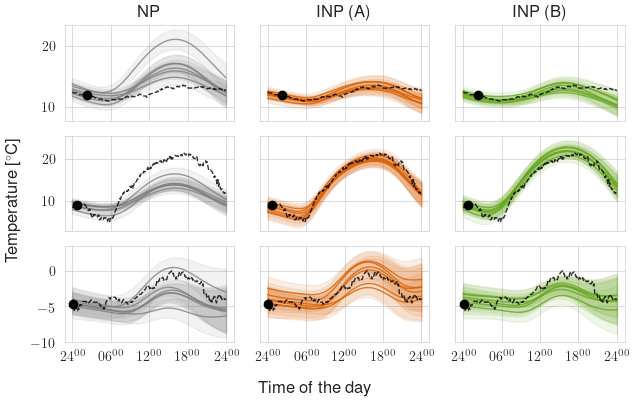

In [27]:
colors = {
    'raw' : 'grey',
    'min_max' : 'C1',
    'desc' : 'C4'
}

fig, axs = plt.subplots(3, 3, figsize=(6.6, 4.2), sharex=True, sharey='row')

for i, eval_type in enumerate(eval_types):
    for j, in_batch_idx in enumerate([0, 4, 7]):
        if eval_type == 'desc':
            print(knowledge[j])
        plot_predictions(
            axs[j][i], in_batch_idx, outputs[eval_type], x_context, y_context, x_target, extras, color=colors[eval_type], plot_true=True, num_z_samples=6
        )

axs[1, 0].set_xticks([-2, -1, 0, 1, 2])
axs[1, 0].set_xticklabels(['$24^{00}$', '$06^{00}$', '$12^{00}$', '$18^{00}$', '$24^{00}$'])
axs[0,0].set_title('NP') 
axs[0,1].set_title('INP (A)')
axs[0,2].set_title('INP (B)')

fig.supylabel('Temperature [$^\circ$C]', x=0.03) 
fig.supxlabel('Time of the day', y=0.03) 
plt.tight_layout()
#plt.savefig('../figures/temperature_predictions.pdf', bbox_inches='tight')
plt.show()